<a href="https://colab.research.google.com/github/suprabhathk/FoundationalModels_TimeSeries_Epidemics/blob/main/FoundationModels_TimeSeries_InflucastExperiment_TimeGPT_TimesFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Using the influcast dataset to run and assess performance of time series foundation models (TimesFM, TimeGPT)***

### **1.Importing the influcast repository**

In [6]:
# Importing dependencies for data import
import pandas as pd
import requests
from io import StringIO

In [7]:
def get_last_available_week_data(year):
    """
    Try to get the last available weekly data for a season by checking weeks in reverse order
    """
    base_url = "https://raw.githubusercontent.com/Predizioni-Epidemiologiche-Italia/Influcast/main/sorveglianza/ILI"
    season = f"{year}-{year+1}"

    # Try weeks in reverse order for the second year (most likely to have the final data)
    for week in range(20, 0, -1):  # Try weeks 20 down to 1
        file_name = f"italia-{year+1}_{week:02d}-ILI.csv"
        url = f"{base_url}/{season}/{file_name}"

        try:
            df = pd.read_csv(url)
            print(f"Found data for {season} at week {week} of {year+1}")
            return df
        except:
            continue

    # If not found, try end weeks of first year
    for week in range(53, 39, -1):  # Try weeks 53 down to 40
        file_name = f"italia-{year}_{week:02d}-ILI.csv"
        url = f"{base_url}/{season}/{file_name}"

        try:
            df = pd.read_csv(url)
            print(f"Found data for {season} at week {week} of {year}")
            return df
        except:
            continue

    print(f"No data found for season {season}")
    return None

In [8]:
def get_latest_data(year):
    """Helper function to get latest format data (for 2023 onwards)"""
    base_url = "https://raw.githubusercontent.com/Predizioni-Epidemiologiche-Italia/Influcast/main/sorveglianza/ILI"
    season = f"{year}-{year+1}"
    url = f"{base_url}/{season}/latest/italia-latest-ILI.csv"

    try:
        df = pd.read_csv(url)
        return df
    except Exception as e:
        print(f"Error importing {season}: {str(e)}")
        return None


In [9]:
def import_flu_data(start_year=2003, end_year=2024):
    """
    Import flu data from GitHub repository:
    - For 2003-2022: Gets last available weekly data
    - For 2023 onwards: Gets latest format data
    """
    all_dfs = []

    # Handle older years (2003-2022)
    for year in range(start_year, 2023):
        print(f"\nProcessing {year}-{year+1} season...")
        df = get_last_available_week_data(year)
        if df is not None:
            print(f"Entries found: {len(df)}")
            all_dfs.append(df)

    # Handle newer years with latest format (2023-2025)
    for year in range(2023, end_year + 1):
        print(f"\nProcessing {year}-{year+1} season (latest format)...")
        df = get_latest_data(year)
        if df is not None:
            print(f"Entries found: {len(df)}")
            all_dfs.append(df)

    # Combine all data
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"\nFinal dataset shape: {combined_df.shape}")
        return combined_df
    else:
        raise ValueError("No data was successfully imported")

In [10]:
# Import all data
try:
    df_influcast = import_flu_data()
except Exception as e:
    print(f"Error: {str(e)}")


Processing 2003-2004 season...
Found data for 2003-2004 at week 17 of 2004
Entries found: 28

Processing 2004-2005 season...
Found data for 2004-2005 at week 16 of 2005
Entries found: 28

Processing 2005-2006 season...
Found data for 2005-2006 at week 17 of 2006
Entries found: 28

Processing 2006-2007 season...
Found data for 2006-2007 at week 17 of 2007
Entries found: 28

Processing 2007-2008 season...
Found data for 2007-2008 at week 17 of 2008
Entries found: 28

Processing 2008-2009 season...
Found data for 2008-2009 at week 17 of 2009
Entries found: 28

Processing 2009-2010 season...
Found data for 2009-2010 at week 15 of 2010
Entries found: 27

Processing 2010-2011 season...
Found data for 2010-2011 at week 17 of 2011
Entries found: 28

Processing 2011-2012 season...
Found data for 2011-2012 at week 17 of 2012
Entries found: 28

Processing 2012-2013 season...
Found data for 2012-2013 at week 17 of 2013
Entries found: 28

Processing 2013-2014 season...
Found data for 2013-2014 at 

In [11]:
df_influcast

,anno,settimana,incidenza,numero_casi,numero_assistiti,target
0,2003,42,0.360000,357,1000656,ILI
1,2003,43,0.470000,500,1066723,ILI
2,2003,44,0.520000,597,1150866,ILI
3,2003,45,0.600000,723,1204797,ILI
4,2003,46,0.590000,742,1251026,ILI
...,...,...,...,...,...,...
597,2024,52,10.507239,23238,2211618,ILI
598,2025,1,12.355276,27339,2212739,ILI
599,2025,2,14.768421,32995,2234159,ILI
600,2025,3,15.888903,33734,2123117,ILI


In [12]:
# Adding two new columns

# Add new columns
df_influcast['stagione_influenzale'] = df_influcast['anno'].astype(str) + '_' + (df_influcast['anno'] + 1).astype(str)
df_influcast['anno_settimana'] = df_influcast['anno'].astype(str) + '_' + df_influcast['settimana'].astype(str).str.zfill(2)

# Reorder columns
cols = df_influcast.columns.tolist()
# Remove new columns from current position
cols.remove('stagione_influenzale')
cols.remove('anno_settimana')
# Find position of 'settimana' and insert new columns after it
settimana_pos = cols.index('settimana')
cols.insert(settimana_pos + 1, 'stagione_influenzale')
cols.insert(settimana_pos + 2, 'anno_settimana')
# Apply new column order
df_influcast = df_influcast[cols]


In [13]:
df_influcast

,anno,settimana,stagione_influenzale,anno_settimana,incidenza,numero_casi,numero_assistiti,target
0,2003,42,2003_2004,2003_42,0.360000,357,1000656,ILI
1,2003,43,2003_2004,2003_43,0.470000,500,1066723,ILI
2,2003,44,2003_2004,2003_44,0.520000,597,1150866,ILI
3,2003,45,2003_2004,2003_45,0.600000,723,1204797,ILI
4,2003,46,2003_2004,2003_46,0.590000,742,1251026,ILI
...,...,...,...,...,...,...,...,...
597,2024,52,2024_2025,2024_52,10.507239,23238,2211618,ILI
598,2025,1,2025_2026,2025_01,12.355276,27339,2212739,ILI
599,2025,2,2025_2026,2025_02,14.768421,32995,2234159,ILI
600,2025,3,2025_2026,2025_03,15.888903,33734,2123117,ILI


### **2. Splitting the data to exclude COVID years (2020-2022)**

In [14]:
# Create new dataset with years 2020-2022
covid_years_df_influcast = df_influcast[df_influcast['anno'].between(2020, 2022)].copy()

# Keep remaining years in original dataset
without_covid_df_influcast = df_influcast[~df_influcast['anno'].between(2020, 2022)].copy()

# Print shapes to verify
print("Main dataset shape (excluding 2020-2022):", without_covid_df_influcast.shape)
print("COVID years dataset shape (2020-2022):", covid_years_df_influcast.shape)


Main dataset shape (excluding 2020-2022): (518, 8)
COVID years dataset shape (2020-2022): (84, 8)


In [15]:
# Save datasets to CSV
without_covid_df_influcast.to_csv('influcast_without_covid.csv', index=False)
covid_years_df_influcast.to_csv('influcast_covid_years.csv', index=False)

# TIME GPT
#### Refer https://docs.nixtla.io/docs/getting-started-timegpt_quickstart
#### Refer https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/getting-started/2_quickstart.ipynb


In [16]:
### CREATE ENVIRONMENT FOR TIME GPT
!pip install -Uqq nixtla
from nixtla.utils import in_colab
IN_COLAB = in_colab()
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/getting-started/2_quickstart')


from nixtla import NixtlaClient

# Place to apply API: https://dashboard.nixtla.io/sign_in
nixtla_client = NixtlaClient(
    api_key = 'nixak-hPzK1G9RYbcFusZYj0JzMjfLHvwLDASjQHdRQAksaKRXb8r7g5qqcTYQ25Jjftftkl0REPcGFAc88RR9'
)
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()


nixtla_client.validate_api_key()

True

In [17]:
### CONVERT DATA, THEN TRY THE TEST THEN FILL THE NA VALUE.
timegptdata = without_covid_df_influcast[["anno_settimana", "incidenza"]]

# Convert 'anno_settimana' using .loc to avoid warnings
timegptdata.loc[:, 'anno_settimana'] = timegptdata['anno_settimana'].str.replace('_', '-W') + '-1'
timegptdata.loc[:, 'anno_settimana'] = pd.to_datetime(timegptdata['anno_settimana'], format='%Y-W%W-%w')
timegptdata = timegptdata.drop_duplicates(subset=['anno_settimana'])
# Create a complete weekly time range (Monday start)
full_weekly_range = pd.date_range(start=timegptdata['anno_settimana'].min(),
                                  end=timegptdata['anno_settimana'].max(),
                                  freq='W-MON')

# Reindex to include all weeks and reset index
timegptdata = timegptdata.set_index('anno_settimana').reindex(full_weekly_range).reset_index()
timegptdata.rename(columns={'index': 'anno_settimana'}, inplace=True)
timegptdata['incidenza'] = timegptdata['incidenza'].fillna(method='ffill')


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
<ipython-input-17-2eb52efca1d0>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  timegptdata['incidenza'] = timegptdata['incidenza'].fillna(method='ffill')


In [18]:

#Select the data set
train_df_GPT = timegptdata.iloc[:600]
test_df_GPT = timegptdata.iloc[600:800]
##### PREDICT FUNCTION####

#####  parameter "h" means the length of prediction####
#####  parameter "freq" means the the time step ####
timegpt_fcst_df_predict = nixtla_client.forecast(df=train_df_GPT, h=200, freq='W', time_col='anno_settimana', target_col='incidenza')


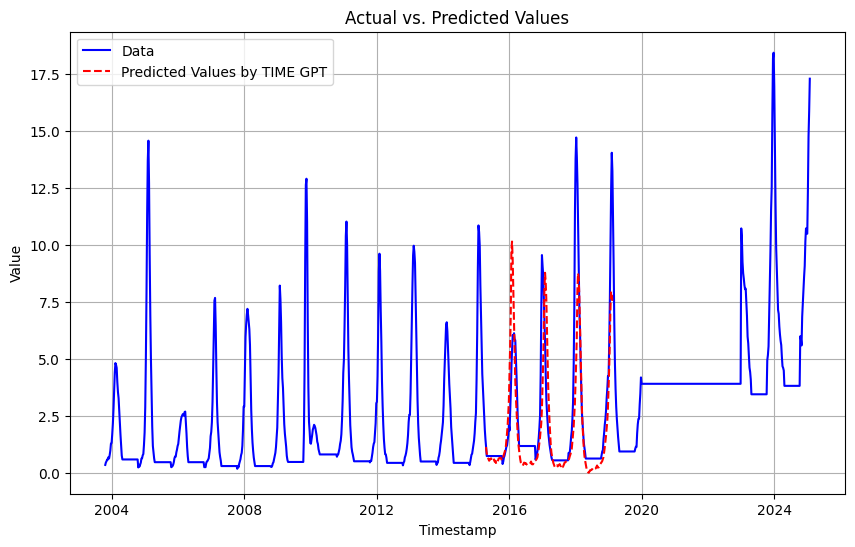

In [19]:
#Visualize RESULT
import matplotlib.pyplot as plt
import pandas as pd


# Plot the results
plt.figure(figsize=(10, 6))

# Actual values (train and test)
plt.plot(timegptdata['anno_settimana'], timegptdata['incidenza'], label='Data', color='blue')

# Predicted values
plt.plot(timegpt_fcst_df_predict['anno_settimana'], timegpt_fcst_df_predict['TimeGPT'], label='Predicted Values by TIME GPT', color='red', linestyle='--')

# Indicate the train-test split
#plt.axvline(x=train_df['timestamp'].iloc[-1], color='black', linestyle='--', label='Train-Test Split')

# Plot customization
plt.title('Actual vs. Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# TIMESFM

### Refer https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb

In [1]:
#PREPARE ENVIRONMENT FOR TIMESFM
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.51.0'),
    ('timesfm', 'timesfm'),
    ('google.cloud.bigquery', 'google-cloud-bigquery')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)



project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import timesfm
import numpy as np
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt


bq = bigquery.Client(project = PROJECT_ID)



Are you sure you wish to set property [core/project] to statmike-mlops-349915?

Do you want to continue (Y/n)?  n

Colab authorized to GCP
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0].


In [2]:
# Deploy the basic tool of tfm
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=200, # Set this to the number of future time steps you want to predict
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

In [20]:
# Focast From TIMESFM
# INPUT IS ONE DIMENSIONAL ARRAY
forecast_input_FM = [train_df_GPT["incidenza"].values]
# youcan change frequency_input,
#0 (default): high frequency, long horizon time series. We recommend using this for time series up to daily granularity.
#1: medium frequency time series. We recommend using this for weekly and monthly data.
#2: low frequency, short horizon time series. We recommend using this for anything beyond monthly, e.g. quarterly or yearly.
frequency_input = [1]
point_forecast_FM, experimental_quantile_forecast_FM = tfm.forecast(
    forecast_input_FM,
    freq=frequency_input,
)


In [21]:
import copy
##GET THE DATAFRAME OF PREDICTION
test_df_fm= copy.copy(test_df_GPT)
test_df_fm["incidenza"] = point_forecast_FM[0]

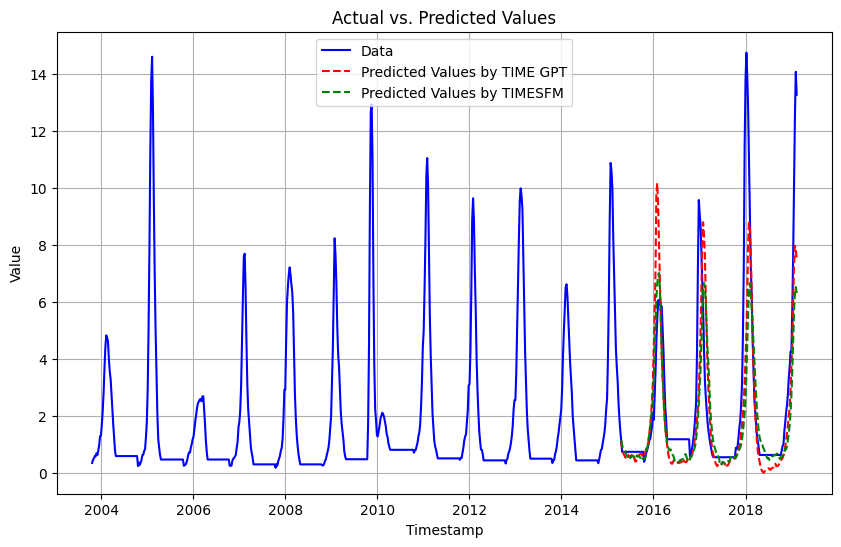

In [22]:
import matplotlib.pyplot as plt
import pandas as pd


# Plot the results
plt.figure(figsize=(10, 6))

# Actual values (train and test)
plt.plot(timegptdata.iloc[:800]['anno_settimana'], timegptdata.iloc[:800]['incidenza'], label='Data', color='blue')

# Predicted values
plt.plot(timegpt_fcst_df_predict['anno_settimana'], timegpt_fcst_df_predict['TimeGPT'], label='Predicted Values by TIME GPT', color='red', linestyle='--')
plt.plot(test_df_fm['anno_settimana'], test_df_fm['incidenza'], label='Predicted Values by TIMESFM', color='green', linestyle='--')

# Indicate the train-test split
#plt.axvline(x=train_df['timestamp'].iloc[-1], color='black', linestyle='--', label='Train-Test Split')

# Plot customization
plt.title('Actual vs. Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


